In [4]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.style.use('ggplot')
plt.rc('font', size=15)
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True) # 온라인이 아닌 상황에서 처리를 위한 명시 코드

from tqdm import tqdm_notebook

from eunjeon import Mecab

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
gensim.__version__  # '3.8.3'

from sklearn.decomposition import PCA

In [5]:
import preprocess_kr

In [6]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.options.display.float_format = '{:.2f}'.format

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# 전처리된 정제된 파일을 사용한다.
df = pd.read_table('./data/kr_전지적 독자 시점_episode_total_cleaned_list.txt', header =None)

In [9]:
df.columns = ['Review']
df.head()

,Review
0,전설이 시작된다
1,전독시 소설은 안봤는데 이거 재밌움 웨툰은 일단 존잼
2,나는유중혁이다
3,소설은 완결났길래 이것도 완결 가까워지면 몰아보려고 하는데 지금 전개가 소설 몇화쯤인가요
4,정주행가는중


# mecab 토큰화 및 불용어 제거

In [10]:
def get_tokenized_data(df):
    """
    mecab 형태소 분석기를 이용하여 토큰화 및 불용어 제거하는 함수¶
    """
    
    # 불용어 생성
    stopwords = preprocess_kr.make_stop_words()

    # mecab 형태소 분석기 객체 생성 
    mecab = Mecab('C:/mecab/mecab-ko-dic')

    # 결과 리스트
    tokenized_data = []

    # 원래 진행하고자했던 반복문 for i in range(100)에서 'in' 뒤에 문장을 tqdm()으로 감싸주면 진행 상황이 bar로 표현된다.
    # tqdm_notebook 은 tqdm 의 Jupiter Notebook version, progress bar가 예쁘다.
    for sentence in tqdm_notebook(df['Review']):
        tokenized_sentence = mecab.morphs(sentence) # mecab 문장 토큰화

        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거    
        stopwords_removed_sentence = [word for word in stopwords_removed_sentence if len(word) > 1] # 한글자 제거

        tokenized_data.append(stopwords_removed_sentence)
        
    return tokenized_data

def show_review_info(tokenized_data):
    """
    리뷰 길이 분포 확인 함수
    """
    print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
    print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
    plt.hist([len(review) for review in tokenized_data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
def get_model_wv(tokenized_data):
    """
    토큰화된 데이터를 Word2Vec 알고리즘을 학습시켜 모델을 반환하는 함수
    """
    # Word2Vec으로 토큰화된 tokenized_data를 학습
    from gensim.models import Word2Vec
    # gensim 4.2 vector_size
    # gensim 3.8.3 size
    model = Word2Vec(sentences = tokenized_data, size = 200, window = 2, min_count = 50, workers = 4, sg = 1)
    
    # embedding_model = Word2Vec(tokenized_contents, size=100, window = 2, min_count=50, workers=4, iter=100, sg=1)
    
    # 포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 
    # 주변 단어(window)는 앞뒤로 두개까지 보되, 
    # 코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외해라. 
    # CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 
    # 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
    
    # Word2Vec 임베딩 행렬의 크기를 확인
    print("model.wv.vectors.shape: ",model.wv.vectors.shape)
    
    return model    

def print_most_similar_words(model, words_list): 
    """
    특정단어 리스트를 입력받아 유사도를 출력하는 함수
    """
    similar_words = []
    for keyword in words_list:        
        similar_words.append(model.wv.most_similar(keyword))
        print('[', keyword, '] 와 관련있는 단어들 :' , similar_words)
        print()
    return similar_words
        
def get_similarity_btw_two_words(model, w1,w2):
    """
    단어간 유사도 확인 함수
    """
    
    # 모델로부터 단어벡터를 구한다.
    word_vectors = model.wv
    
    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]

    # 단어간 유사도를 반환
    return word_vectors.similarity(w1, w2)
        
def get_similarity_df(keyword):
    """
    특정 키워드를 입력받아 관련있는 단어를 찾고 유사도를 구하는 함수
    """
    similar_word = model.wv.most_similar(keyword)
    similar_word_df = pd.DataFrame(similar_word)
    similar_word_df.columns=["유사단어","유사도"]
    similar_word_df
    return similar_word_df   

def plot_2d_graph(vocabs, xs, ys):
    """
    단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그리는 함수
    """
    plt.figure(figsize=(10,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))    
        
def reduce_dimension_PCA(word_vectors_list):
    """
    PCA를 이용하여 차원을 축소하는 함수
    """
    pca = PCA(n_components=2)
    xys = pca.fit_transform(word_vectors_list[:10])
    xs = xys[:,0]
    ys = xys[:,1]
    return xs, ys        

# 1. 토큰화

In [11]:
tokenized_data = get_tokenized_data(df)
tokenized_data[:10]

stop_words made


  0%|          | 0/276161 [00:00<?, ?it/s]

[['전설', '시작'],
 ['전독시', '소설'],
 ['유중혁'],
 ['소설', '완결', '완결', '가까워', '전개', '소설'],
 ['정주', '행가'],
 ['전독시', '웹툰', '소설', '그림', '별론데', '그림', '체고', '독시', '만들', '함하', '사랑'],
 ['작가', '결말'],
 ['전독시',
  '당하',
  '댓글',
  '들어온',
  '화면',
  '확인',
  '수가',
  '답글',
  '제외',
  '답글',
  '유독',
  '답글',
  '보인다면',
  '내용',
  '차단',
  '도록',
  '개꿀',
  '기억',
  '기분',
  '망치',
  '전체',
  '댓글',
  '구분',
  '으므로',
  '장합'],
 ['김독자', '못생긴', '설정'],
 ['주행', '시작']]

# 2. 댓글 정보 확인

리뷰의 최대 길이 : 250
리뷰의 평균 길이 : 4.295885371214617


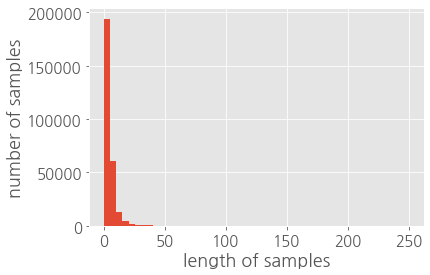

In [12]:
show_review_info(tokenized_data)

# 3. tokenized_data로 모델을 학습

In [13]:
model = get_model_wv(tokenized_data)

model.wv.vectors.shape:  (3084, 200)


In [14]:
# 모델을 저장한다.
model.save('./data/word2vec_kr.model')
 
# 저장한 모델을 읽어온다.
model = Word2Vec.load('./data/word2vec_kr.model')

# 4. 유사단어 검색

In [15]:
words_list = ['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']
topics = print_most_similar_words(model, words_list)
topics

[ 독자 ] 와 관련있는 단어들 : [[('김독자', 0.6757687330245972), ('아니야', 0.6010410189628601), ('유미아', 0.5919913053512573), ('위로', 0.5918104648590088), ('파해', 0.5860544443130493), ('초면', 0.5814056396484375), ('바라보', 0.5807805061340332), ('거울', 0.5765043497085571), ('시여', 0.563570499420166), ('풀린', 0.5630496144294739)]]

[ 소설 ] 와 관련있는 단어들 : [[('김독자', 0.6757687330245972), ('아니야', 0.6010410189628601), ('유미아', 0.5919913053512573), ('위로', 0.5918104648590088), ('파해', 0.5860544443130493), ('초면', 0.5814056396484375), ('바라보', 0.5807805061340332), ('거울', 0.5765043497085571), ('시여', 0.563570499420166), ('풀린', 0.5630496144294739)], [('원작', 0.7296383380889893), ('행중', 0.7269852757453918), ('행하', 0.7182834148406982), ('완독', 0.6833899617195129), ('감회', 0.6796732544898987), ('정독', 0.6749428510665894), ('화수', 0.6729522347450256), ('새롭', 0.667960524559021), ('신선', 0.6659985780715942), ('맞춰서', 0.6633583307266235)]]

[ 작가 ] 와 관련있는 단어들 : [[('김독자', 0.6757687330245972), ('아니야', 0.6010410189628601), ('유미아', 0.59199130535125

[[('김독자', 0.6757687330245972),
  ('아니야', 0.6010410189628601),
  ('유미아', 0.5919913053512573),
  ('위로', 0.5918104648590088),
  ('파해', 0.5860544443130493),
  ('초면', 0.5814056396484375),
  ('바라보', 0.5807805061340332),
  ('거울', 0.5765043497085571),
  ('시여', 0.563570499420166),
  ('풀린', 0.5630496144294739)],
 [('원작', 0.7296383380889893),
  ('행중', 0.7269852757453918),
  ('행하', 0.7182834148406982),
  ('완독', 0.6833899617195129),
  ('감회', 0.6796732544898987),
  ('정독', 0.6749428510665894),
  ('화수', 0.6729522347450256),
  ('새롭', 0.667960524559021),
  ('신선', 0.6659985780715942),
  ('맞춰서', 0.6633583307266235)],
 [('신가요', 0.6361414194107056),
  ('숑님', 0.6042706966400146),
  ('택배', 0.5815709829330444),
  ('슬리피', 0.5691442489624023),
  ('만수무강', 0.5654990673065186),
  ('체로', 0.5505855083465576),
  ('체도', 0.5485982894897461),
  ('이분', 0.5443755388259888),
  ('오래오래', 0.5419575572013855),
  ('신임', 0.5403145551681519)],
 [('작화', 0.7520590424537659),
  ('체가', 0.7091229557991028),
  ('체도', 0.6899300813674927)

In [16]:
topic_list = []
for topic in words_list:
    topic_list.append(topic)
    topic_list.append(topic)
topic_list

['독자',
 '독자',
 '소설',
 '소설',
 '작가',
 '작가',
 '그림',
 '그림',
 '연출',
 '연출',
 '주인공',
 '주인공',
 '캐릭터',
 '캐릭터',
 '원작',
 '원작',
 '작화',
 '작화',
 '스토리',
 '스토리']

In [17]:
df = pd.DataFrame(data=[], 
                  index = ['0','1','2','3','4','5','6','7','8','9'],
                  columns=[ topic_list,  ['topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity']])  

for index,topic in enumerate(topics): 
    for idx, tup in enumerate(topic):
        word, similarity = tup
        topic_name = words_list[index]
        df[topic_name,'topic'][idx] = word
        df[topic_name,'similarity'][idx] = similarity
df

독자               소설               작가               그림               연출  \
  topic similarity topic similarity topic similarity topic similarity topic   
0   김독자       0.68    원작       0.73   신가요       0.64    작화       0.75   연출력   
1   아니야       0.60    행중       0.73    숑님       0.60    체가       0.71    천칭   
2   유미아       0.59    행하       0.72    택배       0.58    체도       0.69    지린   
3    위로       0.59    완독       0.68   슬리피       0.57    신다       0.67   이펙트   
4    파해       0.59    감회       0.68  만수무강       0.57    고퀄       0.66    투신   
5    초면       0.58    정독       0.67    체로       0.55    체로       0.66    표현   
6   바라보       0.58    화수       0.67    체도       0.55    레드       0.65    함대   
7    거울       0.58    새롭       0.67    이분       0.54   스러움       0.65    쳣다   
8    시여       0.56    신선       0.67  오래오래       0.54    섬세       0.65    개지   
9    풀린       0.56   맞춰서       0.66    신임       0.54    채색       0.64    수왕   

                주인공              캐릭터               원작               작화  \
  similarity  topic similarity topic similarity topic similarity topic   
0       0.81     악당       0.68    캐릭       0.83    소설       0.73   퀄리티   
1       0.80     버프       0.63    매력       0.76   따라가       0.69    그림   
2       0.77     찌르       0.60    주연       0.75    반영       0.68    투신   
3       0.76     치킨       0.60    조연       0.74    에바       0.68   연출력   
4       0.74     인칭       0.59  엑스트라       0.68   빠져서       0.68    쳣다   
5       0.74  사이코패스       0.59    악역       0.68   아쉬운       0.67    오져   
6       0.74     구마       0.59   반가워       0.68   어떨까       0.67    퀄이   
7       0.73     패스       0.59   디자인       0.67  어마어마       0.66    지린   
8       0.73     조연       0.59    바꾼       0.66    중후       0.66    체도   
9       0.72    라지만       0.58    성향       0.65    접하       0.66    액션   

               스토리             
  similarity topic similarity  
0       0.78    깔끔       0.73  
1       0.75    참신       0.73  
2       0.75    느린       0.72  
3       0.73    구성       0.72  
4       0.71   흘러가       0.71  
5       0.70    흥미       0.71  
6       0.70    흐름       0.71  
7       0.70  어마어마       0.70  
8       0.70    방대       0.70  
9       0.68    느리       0.69

In [189]:
df_topic1 = df['스토리','topic']
#df_topic1.columns = ['Name']
df_topic1 = df_topic1.to_frame()
df_topic1.columns = ['Name']
df_topic1['Type1'] = '스토리'
df_topic1['similarity'] = df['스토리','similarity']
df_topic1

,Name,Type1,similarity
0,깔끔,스토리,0.73
1,참신,스토리,0.73
2,느린,스토리,0.72
3,구성,스토리,0.72
4,흘러가,스토리,0.71
5,흥미,스토리,0.71
6,흐름,스토리,0.71
7,어마어마,스토리,0.70
8,방대,스토리,0.70
9,느리,스토리,0.69


In [166]:
type(df_topic1['Name'].values[i])

str

# 네트워크 차트

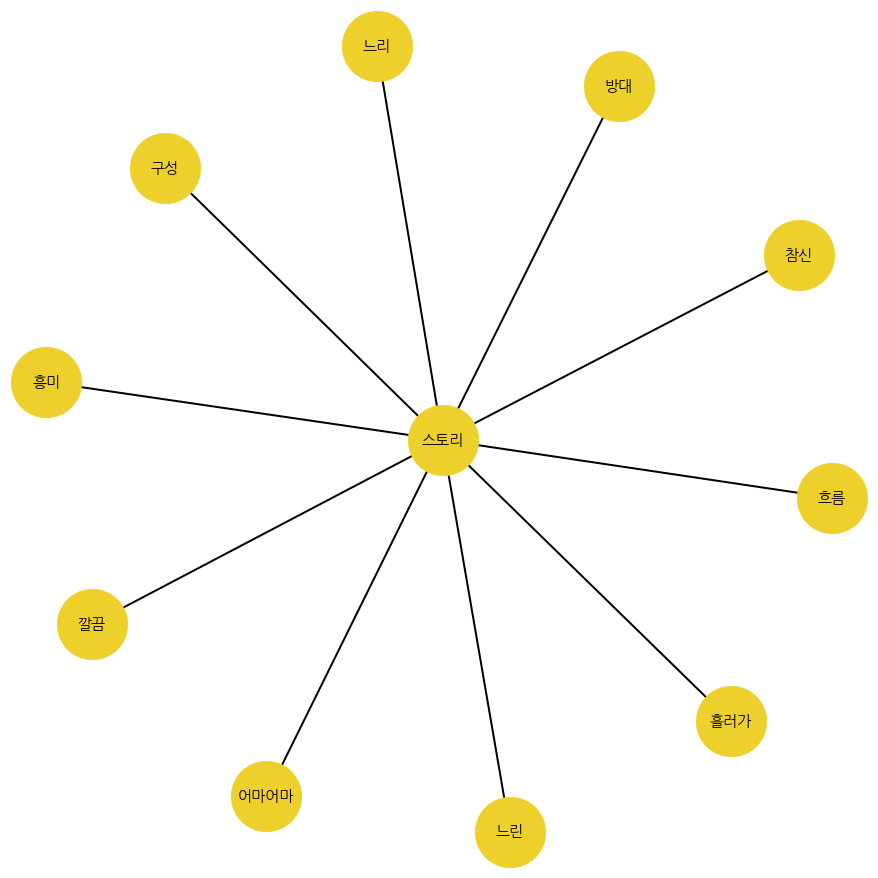

In [216]:
# !pip install decorator==5.0.9
# !pip install networkx==2.6.1 
"""
decorator와 networkx 모듈 사이의 종속성 때문에 발생하는 문제이다.

- decorator 모듈을 5.0.9 이상으로 재설치해주고

- networkx 도 2.6.1 이상으로 재설치해준 후

- 커널을 껐다 키면 문제가 해결된다.  

https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
"""

import networkx as nx
import numpy as np

# Check what size our graph is, and assign stylings
# if size == 'huge':
#         fig_size = (50,50)
#         font_size = 20
#         lwidth = 3
#         arrow_size = 20
#         node_dot = 20
# if size == 'large':
#         fig_size = (40,40)
#         font_size = 16
#         lwidth = 1
#         arrow_size = 10
#         node_dot = 10
# if size == 'medium':
#         fig_size = (25,25)
#         font_size = 12
#         lwidth = 0.8
#         arrow_size = 8
#         node_dot = 8
# if size == 'small':
#         fig_size = (10,10)
#         font_size = 8
#         lwidth = 0.6
#         arrow_size = 6
#         node_dot = 6
# if size == 'tiny':
#         fig_size = (5,5)
#         font_size = 6
#         lwidth = 0.4
#         arrow_size = 5
                
g = nx.Graph()
g = nx.from_pandas_edgelist(df_topic1, source='Name',target='Type1')

# nx.circular_layout(g)

plt.figure(figsize = (12, 12))
# nx. draw_networkx
nx.draw(g,  with_labels = True, node_color = '#edd02b', 
                 width = 2.0,
                 node_size = 5000, font_size = 15, font_family ='NanumGothic')
plt.show()    


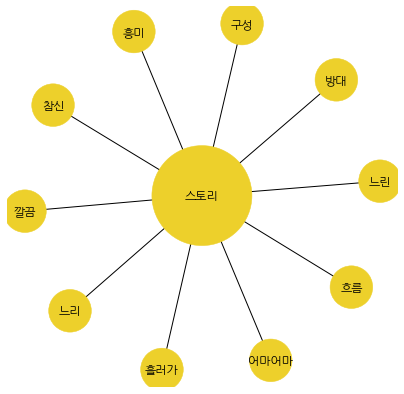

In [228]:
G_symmetric = nx.Graph()
G_symmetric = nx.from_pandas_edgelist(df_topic1, source='Name',target='Type1')
# print(nx.info(G_symmetric))

pos = nx.spring_layout(G_symmetric)
betCent = nx.betweenness_centrality(G_symmetric, normalized=True, endpoints=True)


node_color = [20000.0 * G_symmetric.degree(v) for v in G_symmetric]
node_size =  [v * 10000 for v in betCent.values()]

pr = nx.pagerank(g)
# print(nsize)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize -min(nsize)/ (max(nsize) - min(nsize)))


plt.figure(figsize=(7,7))
nx.draw_networkx(G_symmetric, pos=pos, with_labels=True,
#                  node_color=node_color,
                 node_size=node_size,
                 node_color = '#edd02b',
                 font_family ='NanumGothic')
plt.axis('off');

#  5. 단어간 유사도 확인(동작 안 함)

In [ ]:
# get_similarity_btw_two_words(model, '김독자 ','한수영')

# 6. 유사단어와 유사도를 데이터프레임으로 확인

In [ ]:
words_list

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import plotly
import cufflinks as cf
import pandas as pd
import numpy as np

for word in words_list:
    
    similar_word_df = get_similarity_df(word)
    fig = similar_word_df.iplot(kind='pie',labels = "유사단어", 
                                    values="유사도", textinfo="percent+label",
                                    title= word + ' 관련 단어 Top10', hole = 0.5, asFigure=True)
    filename = './data/'+ word + '.html'   
    #plotly.offline.plot(fig,filename=filename)
    fig.show()

# 7. PCA 차원 축소 및 유사도 시각화(동작 안 함)

In [ ]:
# xs, ys = reduce_dimension_PCA(word_vectors_list)
# plot_2d_graph(vocabs, xs, ys)